# Torch vs. ONNX

Verify that the spike detection output of torch vs. onnx in python is concordant


In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load Trained Model


In [ ]:
# Instantiate a trained model
import json
import numpy as np
import torch
from braindance.core.spikedetector.model import ModelSpikeSorter

# detection_model = ModelSpikeSorter.load("checkpoints/spikedetector/mea")

with open("checkpoints/spikedetector/mea/init_dict.json", "r") as f:
    init_dict = json.load(f)
pytorch_model = ModelSpikeSorter(**init_dict)
state_dict = torch.load(
    "checkpoints/spikedetector/mea/state_dict.pt", map_location="cpu"
)
pytorch_model.load_state_dict(state_dict)

## Load and Scale Traces

Load a recording and scale for the loaded model


In [ ]:
# Extract traces
from braindance.core.spikesorter.rt_sort import save_traces

path = save_traces(
    recording="data/MEA_rec_patch_ground_truth_cell7.raw.h5",
    inter_path="data/",
    start_ms=0,
    end_ms=5000,
    num_processes=None,
    dtype="float16",
    verbose=True,
)

# Load traces
scaled_traces = np.load("data/pytorch/scaled_traces.npy")[:, 0:5000]

Saving traces:


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


In [47]:
# Scale via model parameters and convert to torgh
traces_torch = torch.tensor(
    scaled_traces,
    dtype=torch.float16,
)
traces_torch -= torch.median(traces_torch, dim=1, keepdim=True).values

model_input = traces_torch[:, None, :] * pytorch_model.input_scale

## Find Spikes

Plot the traces and fine spikes via threshold


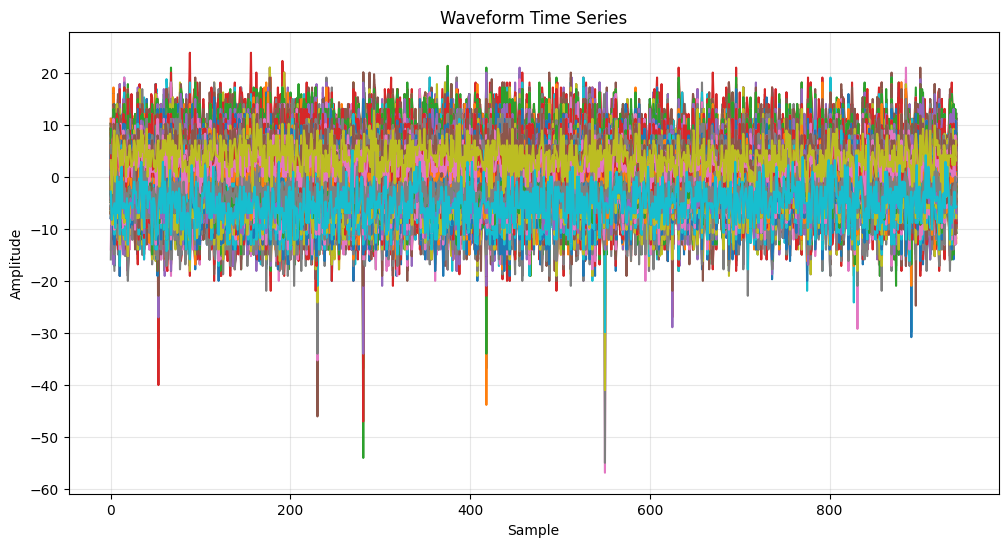

In [36]:
import matplotlib.pyplot as plt

# Plot the waveform as a time series
plt.figure(figsize=(12, 6))
waveform_data = model_input.squeeze().numpy()  # Remove batch and channel dimensions
time_points = np.arange(len(waveform_data))
plt.plot(time_points, waveform_data)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform Time Series")
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
# Find spikes (values below -30) in model_input
waveform_data = model_input.squeeze().numpy()

# Handle both single and multi-channel cases
if len(waveform_data.shape) == 2:
    num_channels, sequence_length = waveform_data.shape

    spike_locations = []
    for channel in range(num_channels):
        # Find sample indices where values go below -30
        spike_samples = np.where(waveform_data[channel] < -30)[0]

        if len(spike_samples) > 0:
            print(
                f"Channel {channel}: {len(spike_samples)} spikes at samples {spike_samples}"
            )
            # Store channel and sample pairs
            for sample in spike_samples:
                spike_locations.append(
                    (channel, sample, waveform_data[channel, sample])
                )
        # else:
        #     print(f"Channel {channel}: No spikes detected")

    # Summary of all spikes
    print(f"\nTotal spikes found: {len(spike_locations)}")
    if spike_locations:
        print("(Channel, Sample, Value):")
        for channel, sample, value in spike_locations:
            print(f"  ({channel}, {sample}, {value:.2f})")

else:
    # Single channel case
    spike_samples = np.where(waveform_data < -30)[0]
    print(f"Single channel: {len(spike_samples)} spikes at samples {spike_samples}")
    if len(spike_samples) > 0:
        for sample in spike_samples:
            print(f"  Sample {sample}: {waveform_data[sample]:.2f}")

Channel 53: 2 spikes at samples [1522 1523]
Channel 230: 4 spikes at samples [234 235 236 237]
Channel 281: 5 spikes at samples [2780 2781 2782 2783 2784]
Channel 418: 3 spikes at samples [1080 1081 1082]
Channel 550: 3 spikes at samples [1386 1387 1388]
Channel 891: 1 spikes at samples [950]

Total spikes found: 18
(Channel, Sample, Value):
  (53, 1522, -33.03)
  (53, 1523, -40.03)
  (230, 234, -37.19)
  (230, 235, -46.06)
  (230, 236, -35.28)
  (230, 237, -34.00)
  (281, 2780, -30.83)
  (281, 2781, -36.84)
  (281, 2782, -54.03)
  (281, 2783, -47.03)
  (281, 2784, -34.00)
  (418, 1080, -36.84)
  (418, 1081, -43.84)
  (418, 1082, -34.00)
  (550, 1386, -56.88)
  (550, 1387, -54.97)
  (550, 1388, -41.00)
  (891, 950, -30.83)


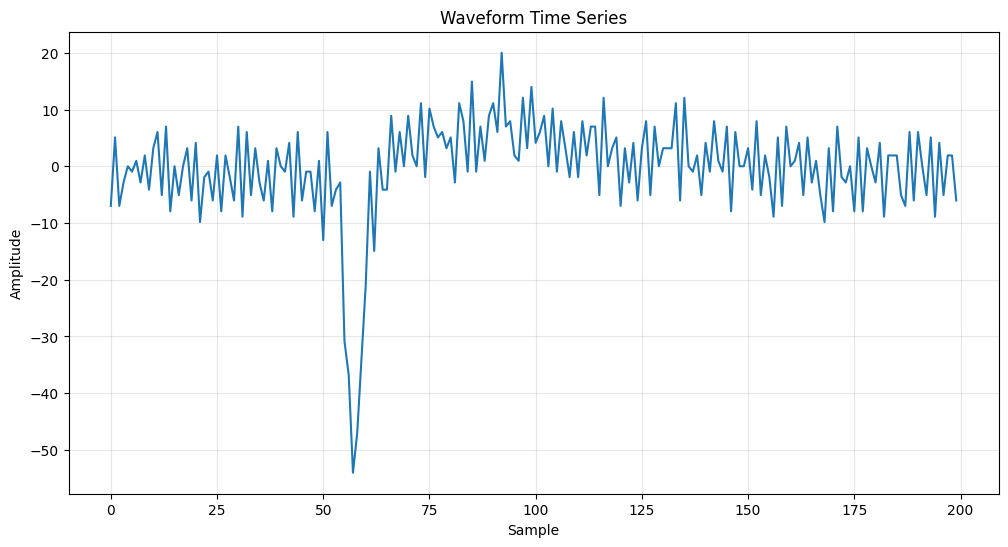

In [64]:
channel_num = 281
start_frame = 2725
test_input = model_input[
    channel_num : channel_num + 1,
    :,
    start_frame : start_frame + pytorch_model.sample_size,
]

# Plot the waveform as a time series
plt.figure(figsize=(12, 6))
waveform_data = test_input.squeeze().numpy()  # Remove batch and channel dimensions
time_points = np.arange(len(waveform_data))
plt.plot(time_points, waveform_data)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform Time Series")
plt.grid(True, alpha=0.3)
plt.show()

## PyTorch Run


In [65]:
pytorch_outputs = pytorch_model.model(test_input).cpu()

np.save("data/pytorch/model_outputs.npy", pytorch_outputs.detach().numpy())
pytorch_outputs

tensor([[-13.6250, -14.7969, -13.3125,  -6.2773,  -1.3857,  -7.5039,  -4.9727,
          -1.5771,  -4.4766,  -3.3750,   0.2764,  -8.0391, -25.4375, -35.5625,
         -22.5312, -37.4062, -24.8281,  33.7812, -17.9531, -29.0156, -29.5781,
         -22.5156, -23.2500,  -4.4648, -11.4531, -14.6328, -20.4531, -27.2500,
         -28.5625, -12.7266, -12.6406, -14.4531, -11.8828, -11.4844,  -9.9297,
         -10.7109, -11.8203, -12.7109, -13.6953, -10.1250,  -4.4023,  -6.9297,
         -12.1719, -15.5469, -15.5859, -15.2031, -11.3672,  -7.9883,  -5.0586,
          -9.5391, -11.2656,  -7.7539,  -3.0957, -12.0469, -10.3516,  -3.3828,
          -6.4805, -10.3906, -11.9062,  -9.9922, -11.4062,  -9.7344,  -8.5234,
         -10.4453, -10.3203,  -9.9844, -10.0703,  -8.1406,  -7.0547,  -7.5508,
         -10.0469, -11.3125, -10.4688, -10.2891, -10.8828, -10.1250,  -9.3203,
          -8.4844,  -9.6641, -10.3047,  -6.5781,  -4.3203,  -7.1445,  -9.5312,
          -9.3594,  -9.9375,  -9.8125, -10.5859, -11

# Export to .onnx


In [67]:
import onnx

num_channels = init_dict["num_channels_in"]
sample_size = init_dict["sample_size"]

In [68]:
# # Move the model to GPU if needed
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
pytorch_model.eval()  # Set model to evaluation mode
# Convert all parameters to float32
model = pytorch_model.float()  # This casts all parameters to torch.float32

In [69]:
torch.onnx.export(
    pytorch_model.model,
    test_input.to(torch.float32),
    str("models/detect-mea.onnx"),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "sequence_length"},
        "output": {0: "batch_size", 2: "sequence_length"},
    },
    opset_version=12,
    verbose=False,
)

# Run via ONNX Python Runtime


In [70]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("models/detect-mea.onnx")

input_meta = ort_session.get_inputs()[0]
input_name = input_meta.name
onnx_input_shape = input_meta.shape

In [73]:
ort_outs = ort_session.run(["output"], {"input": test_input.to(torch.float).numpy()})
ort_outs

[array([[-13.626229 , -14.797407 , -13.311626 ,  -6.275802 ,  -1.3871067,
          -7.504471 ,  -4.9731884,  -1.57566  ,  -4.478496 ,  -3.3754392,
           0.276124 ,  -8.040169 , -25.439138 , -35.5552   , -22.524403 ,
         -37.414444 , -24.834852 ,  33.78395  , -17.942085 , -29.011082 ,
         -29.577469 , -22.517908 , -23.255264 ,  -4.4635477, -11.452326 ,
         -14.632061 , -20.453394 , -27.243319 , -28.5592   , -12.728677 ,
         -12.639859 , -14.448461 , -11.88386  , -11.484896 ,  -9.928485 ,
         -10.708748 , -11.822754 , -12.707537 , -13.69502  , -10.12126  ,
          -4.403494 ,  -6.927535 , -12.171668 , -15.544573 , -15.584415 ,
         -15.204854 , -11.368081 ,  -7.988372 ,  -5.057248 ,  -9.535412 ,
         -11.267574 ,  -7.752679 ,  -3.09643  , -12.048455 , -10.350956 ,
          -3.3829901,  -6.478144 , -10.390755 , -11.907175 ,  -9.99011  ,
         -11.407286 ,  -9.731988 ,  -8.5260935, -10.447588 , -10.318014 ,
          -9.983055 , -10.073016 ,  -8